In [1]:
import sys
from pathlib import Path
import os
dir_yolov5 = '../../'
sys.path.append(dir_yolov5)

In [2]:
from utils.general import LOGGER, Profile, split_dict, increment_path, print_args, xyxy2xywh, box_iou
from utils.torch_utils import select_device
from utils.calibration_utils import (
    setup_data_model, get_yolo_predictions, get_calibrator, calibration, get_annotations_from_dict, get_preds_from_dict, calib_prep
    )
from utils.torch_utils import smart_inference_mode
from utils.utils_numpy import draw_reliability_graph
from utils.metrics import ap_per_class
from val import process_batch

/Users/llacombe/opt/miniconda3/envs/yolov5_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from argparse import Namespace, ArgumentParser
import datetime
from itertools import islice
import numpy as np
import pandas as pd
import cv2
import pickle
import seaborn as sns
from sklearn.utils.fixes import config_context
from torch.distributed import pickle
from tqdm import tqdm
import yaml
import torch
import os
import sklearn

In [4]:
name_dataset = "VOC"
target_dir = dir_yolov5+"../RESULTS/"+name_dataset+"/calibrate_2022_11_01__10_30"


In [5]:
# opt = dir_yolov5+"config/opt/opt_"+name_dataset+"_detect_S_Hyp0.yaml"

# with open(opt) as f:
#     opt = Namespace(**yaml.safe_load(f))

# device = select_device(opt.device, batch_size=opt.batch_size)

In [6]:
opt = target_dir+"config.yaml"

file_ = os.path.join(target_dir, "config.yaml")
with open(file_) as f:
    config = Namespace(**yaml.safe_load(f))

device = select_device(config.device, batch_size=config.batch_size)

pic_save_dir_ = target_dir+"/data_insight/"
if not os.path.exists(pic_save_dir_):
    os.mkdir(pic_save_dir_)

file_ = os.path.join(target_dir, "var.yaml")
with open(file_) as f:
        var = Namespace(**yaml.safe_load(f))

file_ = os.path.join(target_dir, "config.yaml")
with open(file_) as f:
    config = Namespace(**yaml.safe_load(f))

calib_dict = {}
file_calib = os.path.join(target_dir, "calib_dict.pickle")
if os.path.getsize(file_calib) > 0:      
    with open(file_calib, "rb") as f:
        unpickler = pickle.Unpickler(f)
        calib_dict = unpickler.load()

test_dict = {}
file_test = os.path.join(target_dir, "test_dict.pickle")
if os.path.getsize(file_test) > 0:      
    with open(file_test, "rb") as f:
        unpickler = pickle.Unpickler(f)
        test_dict = unpickler.load()

YOLOv5 🚀 v6.1-643-g707fd74 Python-3.10.6 torch-1.12.1 CPU



In [7]:
annotations_classes = []

for item in test_dict:
    annotations_classes.extend(test_dict[item]["annot_class"].ravel().astype(int))

df_ = pd.DataFrame(annotations_classes).rename(columns={0: "annotated_classes"})
df_["annotated_classes"] = df_["annotated_classes"].map(var.names)

In [8]:
(df_.groupby("annotated_classes").size()/df_.shape[0]).round(4)

annotated_classes
aeroplane      0.0239
bicycle        0.0280
bird           0.0384
boat           0.0192
bottle         0.0398
bus            0.0191
car            0.1019
cat            0.0305
chair          0.0629
cow            0.0205
diningtable    0.0171
dog            0.0395
horse          0.0287
motorbike      0.0278
person         0.3753
pottedplant    0.0372
sheep          0.0191
sofa           0.0200
train          0.0234
tvmonitor      0.0277
dtype: float64

In [9]:
def get_additional_info_graphs(dict_, names):
    predictions_df_ = pd.DataFrame()
    for i, image_path in tqdm(enumerate(dict_)):
        if names[0] in dict_[image_path].keys():
            size_xywh_ = xyxy2xywh(dict_[image_path][names[0]])
            pred_obj_conf = dict_[image_path][names[1]]
            pred_class_conf = dict_[image_path][names[2]]
            pred_df = pd.DataFrame(
                {
                    'arg_max': np.argmax(pred_class_conf, axis=1).ravel(),
                    'objectness': pred_obj_conf.ravel(),
                    'max': np.max(pred_class_conf, axis=1).reshape(pred_obj_conf.shape[0], 1).ravel(),
                    'sum_class': np.sum(pred_class_conf, axis=1).ravel(),
                    'size_box': size_xywh_[:, 2]*size_xywh_[:, 3],
                }
            )
            predictions_df_ = pd.concat((predictions_df_, pred_df))
    return predictions_df_


def plots_obj_df(df, split=None, sav=None):
    display(df.iloc[:, :-1].describe().apply(lambda s: s.apply('{0:.3f}'.format)))
    display(df.iloc[:, :-1].groupby("arg_max", as_index=False).agg(["mean"]).round(3))
    pear_corr = df.iloc[:, :].corr(method='pearson')
    display(pear_corr.style.background_gradient(cmap='Greens', axis=0))
    n_ = 50000
    if df.shape[0] > n_:
        temp_ = df.copy().sample(n_)
    else:
        temp_ = df.copy()
    temp_.reset_index(inplace=True, drop=True)
    print(temp_.columns)

    f, axs = plt.subplots(2, 2, figsize=(16, 8))
    for item, ax in zip(temp_.iloc[:, 1:].columns, axs.flat):
        ax.set_xlabel(item)
        ax.hist(temp_[item], bins=100)
    if sav is not None:
        plt.savefig(pic_save_dir_+sav+"_hist.png", bbox_inches="tight")
    plt.show()
    
    f, axs = plt.subplots(1, 3, figsize=(15, 5))
    for item, ax in zip(list(df.iloc[:, 2:].columns), axs):
        sns.histplot(data=temp_, x=item, y="objectness", bins=100, fill=True, ax=ax)
        ax.set_ylim((0, 1))
    if sav is not None:
        plt.savefig(pic_save_dir_+sav+"_dens.png", bbox_inches="tight")
    plt.show()

In [10]:
# # ALL BBOXS
# names = ["bbox_xyxy_scaled", "obj", "class"]
# predictions_all_df = get_additional_info_graphs(test_dict, names)


# # ALL BBOXS + THRES
# # crop of the above 
# predictions_crp_df = predictions_all_df[predictions_all_df["objectness"]>var.conf_thres]
# predictions_crp_df.reset_index(inplace=True, drop=True)


# # AFTER NMS INITIAL BBOXS
# names = ["bbox_xyxy_scaled_nms", "obj_nms", "class_nms"]
# predictions_nms_df = get_additional_info_graphs(test_dict, names)


In [11]:
# print("All bounding boxes before NMS")
# plots_obj_df(predictions_all_df, sav=name_dataset+"_bf_nms")

# print("-"*70)
# print("Cropped before NMS")
# plots_obj_df(predictions_crp_df, sav=name_dataset+"_bf_nms_crp")

# print("-"*70)
# print("Bounding boxes after NMS")
# plots_obj_df(predictions_nms_df, sav=name_dataset+"_af_nms")

In [12]:
test_dict[list(test_dict.keys())[0]].keys()

dict_keys(['bbox_xywh', 'bbox_xyxy_scaled', 'obj', 'class', 'bbox_xyxy_scaled_nms', 'obj_nms', 'class_nms', 'annot_image_shape', 'annot_bbox_xyxy_scaled', 'annot_bbox', 'annot_class', 'has_detec', 'bbox_xywh_Ocalib', 'obj_Ocalib', 'class_Ocalib', 'bbox_xyxy_scaled_Ocalib', 'obj_Ocalib_obj_y_true', 'obj_Ocalib_calib_obj_score', 'bbox_xyxy_scaled_Ocalib_nms_scaled', 'obj_Ocalib_calib_obj_score_nms', 'class_Ocalib_nms', 'bbox_xyxy_scaled_Ocalib_nms_scaled_Ccalib', 'obj_Ocalib_calib_obj_score_nms_Ccalib', 'class_Ocalib_nms_Ccalib', 'class_Ocalib_nms_Ccalib_class_y_true', 'class_Ocalib_nms_Ccalib_calib_class_score'])

In [13]:
# AFTER CALIBRATION BEFORE NMS
names = ["bbox_xyxy_scaled_Ocalib", "obj_Ocalib_calib_obj_score", "class_Ocalib"]
predictions_crp_df_calib = get_additional_info_graphs(test_dict, names)

# AFTER CALIBRATION NMS
names_after = var.names_after
names = [names_after[0], names_after[1], names_after[2], "extra"]
predictions_nms_df_calib = get_additional_info_graphs(test_dict, names)


2972it [00:01, 1632.20it/s]
2972it [00:00, 5061.86it/s]


Bounding boxes calibrated before NMS


,arg_max,objectness,max,sum_class
count,282741.000,282741.000,282741.000,282741.000
mean,10.663,0.576,0.957,1.011
std,4.908,0.170,0.106,0.041
min,0.000,0.167,0.086,0.283
25%,6.000,0.431,0.980,1.005
50%,14.000,0.536,0.994,1.008
75%,14.000,0.681,0.997,1.012
max,19.000,1.000,1.000,1.644


,objectness,max,sum_class
,mean,mean,mean
arg_max,,,
0,0.568,0.970,1.013
1,0.598,0.934,1.013
2,0.571,0.957,1.011
3,0.544,0.965,1.009
4,0.567,0.974,1.010
5,0.602,0.940,1.015
6,0.601,0.977,1.011
7,0.567,0.926,1.010


,arg_max,objectness,max,sum_class,size_box
arg_max,1.000000,-0.001177,0.010770,-0.005535,0.028935
objectness,-0.001177,1.000000,0.169972,-0.044367,-0.025006
max,0.010770,0.169972,1.000000,0.123157,-0.171780
sum_class,-0.005535,-0.044367,0.123157,1.000000,0.017811
size_box,0.028935,-0.025006,-0.171780,0.017811,1.000000


Index(['arg_max', 'objectness', 'max', 'sum_class', 'size_box'], dtype='object')


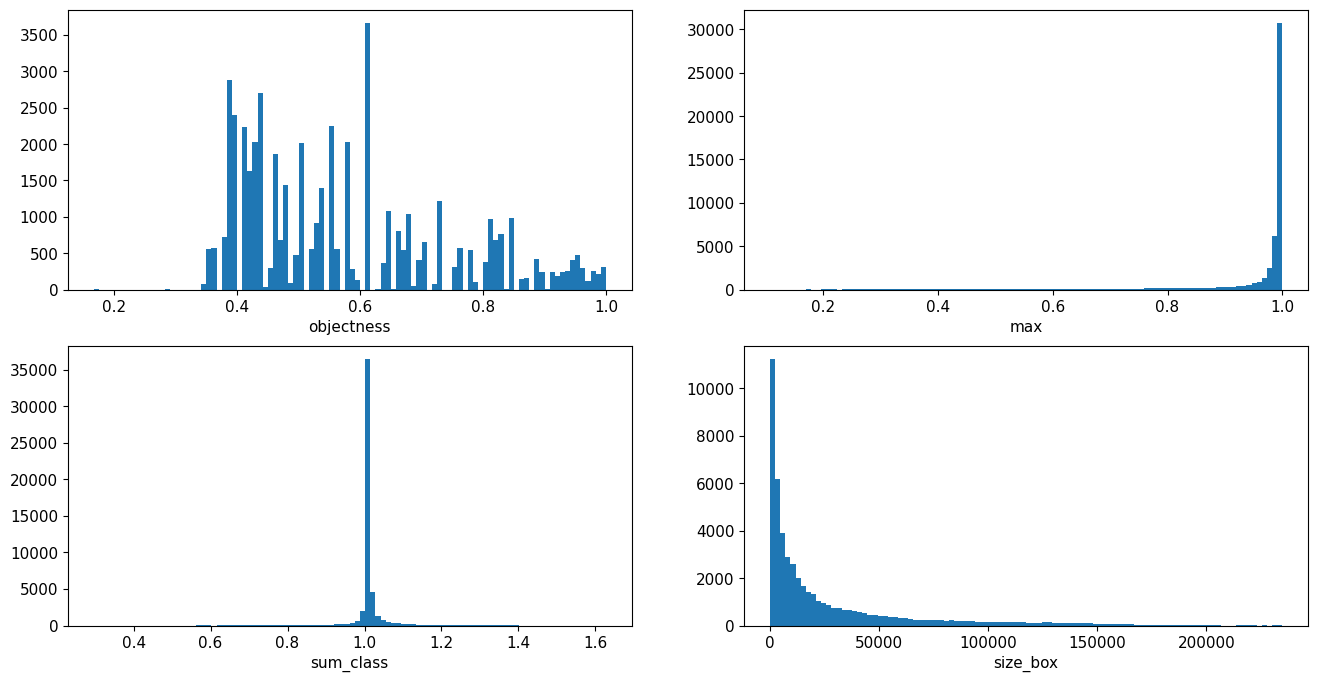

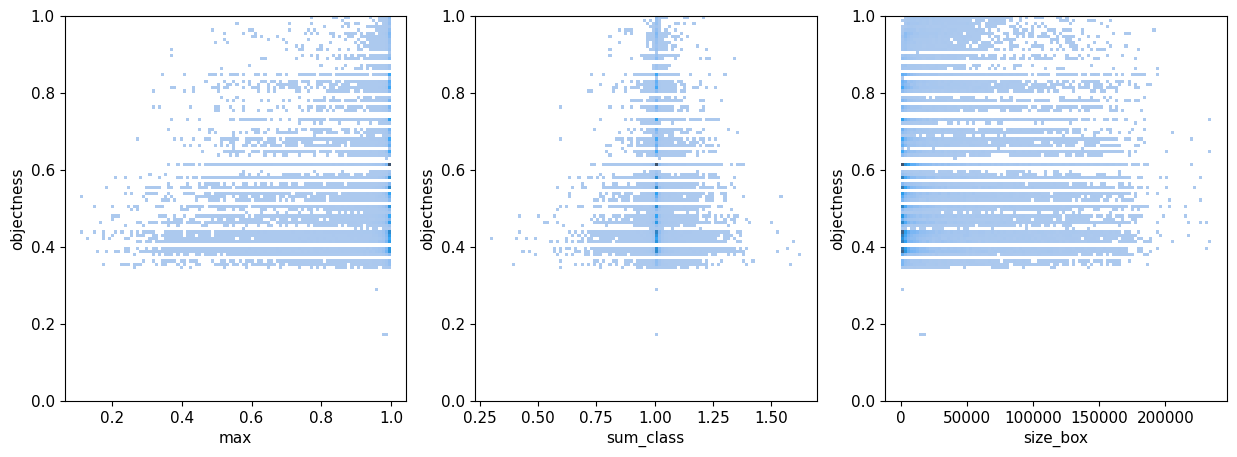

----------------------------------------------------------------------
Bounding boxes calibtrated after NMS


,arg_max,objectness,max,sum_class
count,15844.000,15844.000,15844.000,15844.000
mean,10.684,0.654,0.759,0.989
std,4.882,0.218,0.159,0.194
min,0.000,0.167,0.200,0.443
25%,6.000,0.441,0.651,0.894
50%,14.000,0.612,0.792,0.936
75%,14.000,0.844,0.890,1.049
max,19.000,1.000,1.000,2.752


,objectness,max,sum_class
,mean,mean,mean
arg_max,,,
0,0.635,0.816,0.986
1,0.733,0.814,1.152
2,0.670,0.748,0.963
3,0.592,0.671,0.848
4,0.639,0.677,0.869
5,0.738,0.705,0.882
6,0.700,0.744,0.937
7,0.696,0.873,1.208


,arg_max,objectness,max,sum_class,size_box
arg_max,1.000000,-0.019629,0.111201,0.053689,0.026203
objectness,-0.019629,1.000000,0.433272,-0.181637,0.164113
max,0.111201,0.433272,1.000000,-0.044634,0.036563
sum_class,0.053689,-0.181637,-0.044634,1.000000,0.187373
size_box,0.026203,0.164113,0.036563,0.187373,1.000000


Index(['arg_max', 'objectness', 'max', 'sum_class', 'size_box'], dtype='object')


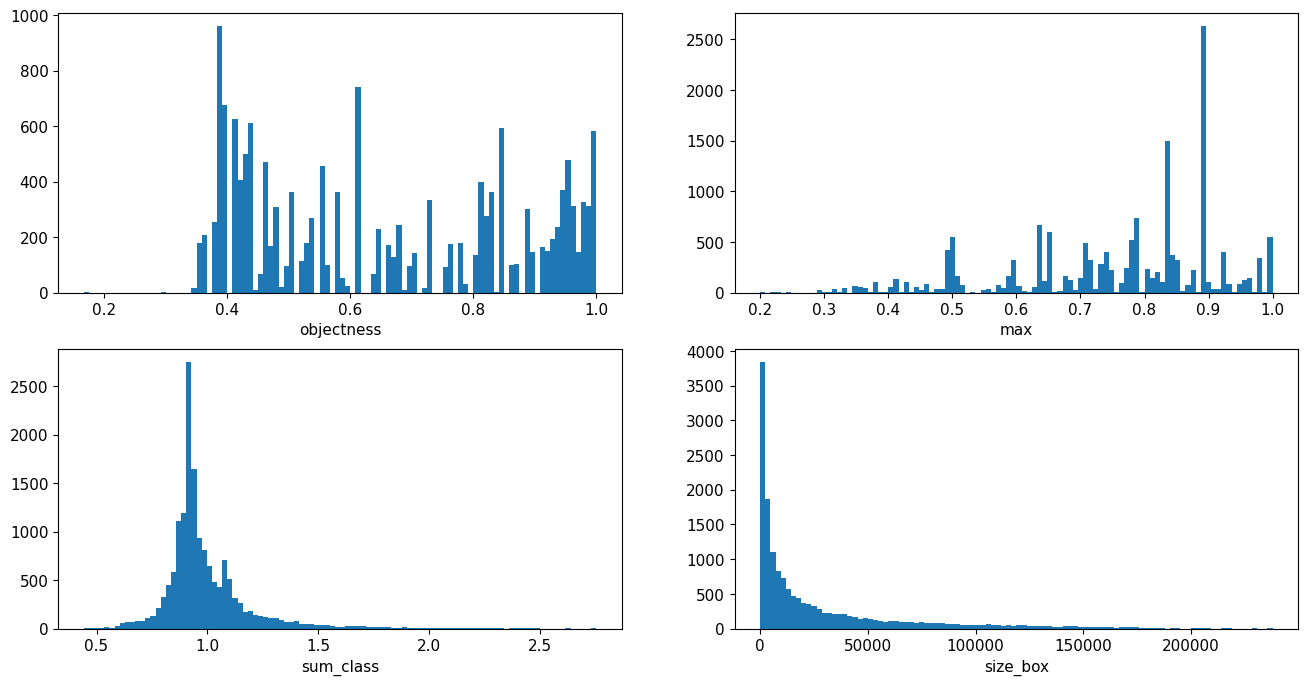

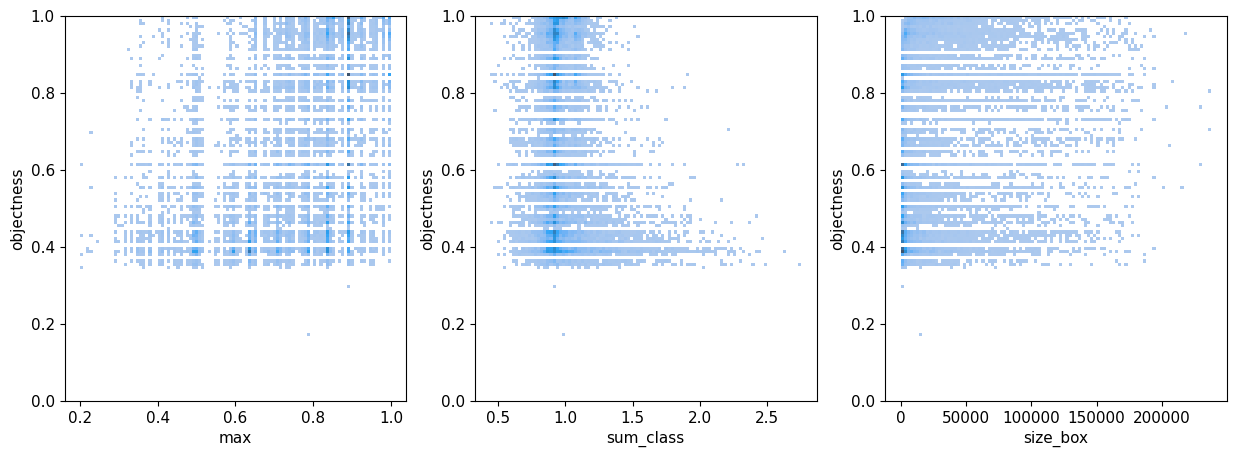

In [14]:
print("Bounding boxes calibrated before NMS")
plots_obj_df(predictions_crp_df_calib, sav=name_dataset+"_bf_nms_calib")

print("-"*70)
print("Bounding boxes calibtrated after NMS")
plots_obj_df(predictions_nms_df_calib, sav=name_dataset+"_af_nms_calib")

In [15]:
names = ["bbox_xyxy_scaled_nms", "obj_nms", "class_nms", "extra"]
labels_for_mAP, labels_for_mAP_numpy = get_annotations_from_dict(test_dict, device)
print(names)
names_copy_original = names.copy()
_ = calib_prep(names, test_dict, var.nc, device, var.conf_thres, var.iou_thres_obj, var.iou_thres_class, "after_nms", obj_calib=True, class_calib=False)

names = ["bbox_xyxy_scaled_nms", "obj_nms", "class_nms"]
original_values, original_values_numpy = get_preds_from_dict(test_dict, names, device)

# BEFORE CALIBRATION OF CLASSES VALUES
names = ["bbox_xyxy_scaled_Ocalib_nms_scaled", "obj_Ocalib_calib_obj_score_nms", "class_Ocalib_nms"]
calibrated_values_, calibrated_values_numpy_ = get_preds_from_dict(test_dict, names, device)

names_after = var.names_after
names = [names_after[0], names_after[1], names_after[2], "extra"]
calibrated_values, calibrated_values_numpy = get_preds_from_dict(test_dict, names, device)
print(names)
names_copy_calibrated = names.copy()
_ = calib_prep(names, test_dict, var.nc, device, var.conf_thres, var.iou_thres_obj, var.iou_thres_class, "after_nms", obj_calib=True, class_calib=False)


['bbox_xyxy_scaled_nms', 'obj_nms', 'class_nms', 'extra']


100%|██████████| 2972/2972 [00:00<00:00, 10032.68it/s]


['bbox_xyxy_scaled_Ocalib_nms_scaled_Ccalib', 'obj_Ocalib_calib_obj_score_nms_Ccalib', 'class_Ocalib_nms_Ccalib_calib_class_score', 'extra']


100%|██████████| 2972/2972 [00:00<00:00, 15653.38it/s]


In [16]:
def max_IoU_with_annotated(labels, other):
    list_iou = []
    list_obj = []
    for annotated, predicted in zip(labels, other):
        iou_ = box_iou(
            annotated[:, 1:],
            predicted[:, :4]
        )
        if iou_.shape[1]!=0:
            iou_max = iou_.max(axis=1)
            iou_max_values = iou_max.values.clone().cpu().numpy()
            iou_max_indices = iou_max.indices.clone().cpu().numpy()
            list_iou.extend(iou_max_values)
            list_obj.extend(predicted[:, 4].cpu().numpy()[iou_max_indices].ravel())
    return list_iou, list_obj

In [17]:
max_IoU_original_values, max_IoU_original_values_obj = max_IoU_with_annotated(labels_for_mAP, original_values)
max_IoU_calibrated_values, max_IoU_calibrated_values_obj = max_IoU_with_annotated(labels_for_mAP, calibrated_values)

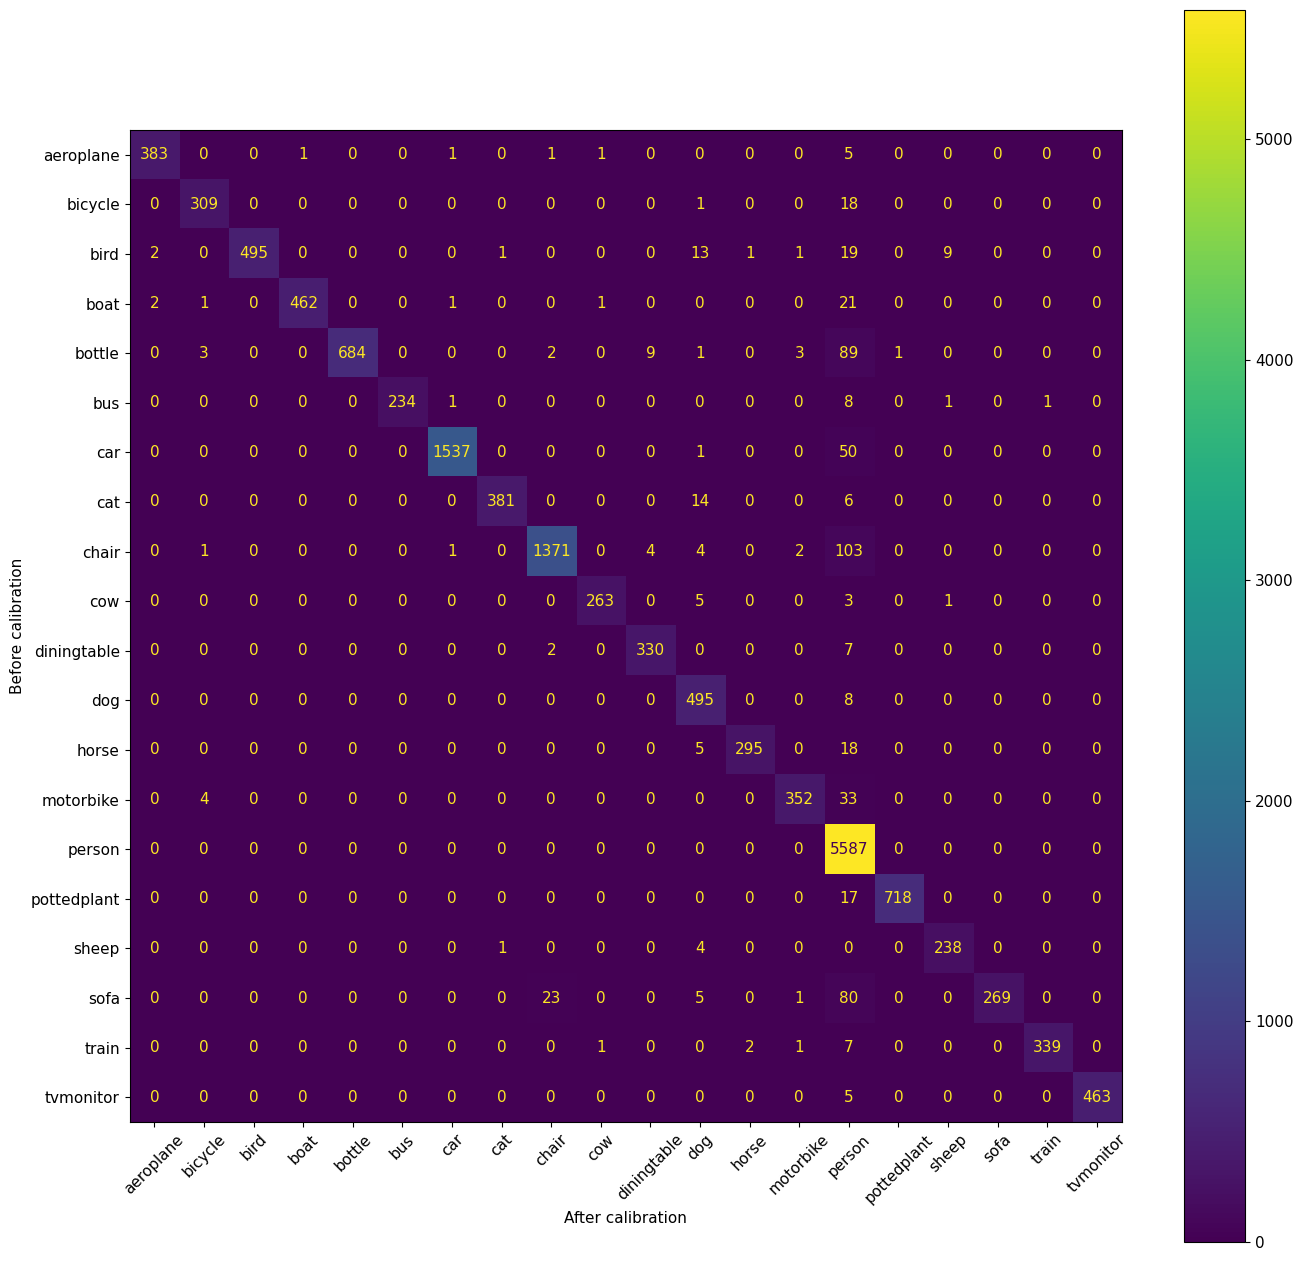

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(16, 16))
original_ = np.argmax(np.vstack([x.cpu().numpy() for x in calibrated_values_])[:, 5:], axis=1)
calibrated_ = np.argmax(np.vstack([x.cpu().numpy() for x in calibrated_values])[:, 5:], axis=1)

name_labels = list(var.names.values())
cm = sklearn.metrics.confusion_matrix(original_, calibrated_)
disp = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=name_labels,
)
disp.plot(ax=axs)
plt.xticks(rotation = 45)
plt.ylabel("Before calibration")
plt.xlabel("After calibration")
plt.savefig(pic_save_dir_+"_confusion_matrix_bf_af_calib.png", bbox_inches="tight")

In [19]:
test_dict[list(test_dict.keys())[0]].keys()

dict_keys(['bbox_xywh', 'bbox_xyxy_scaled', 'obj', 'class', 'bbox_xyxy_scaled_nms', 'obj_nms', 'class_nms', 'annot_image_shape', 'annot_bbox_xyxy_scaled', 'annot_bbox', 'annot_class', 'has_detec', 'bbox_xywh_Ocalib', 'obj_Ocalib', 'class_Ocalib', 'bbox_xyxy_scaled_Ocalib', 'obj_Ocalib_obj_y_true', 'obj_Ocalib_calib_obj_score', 'bbox_xyxy_scaled_Ocalib_nms_scaled', 'obj_Ocalib_calib_obj_score_nms', 'class_Ocalib_nms', 'bbox_xyxy_scaled_Ocalib_nms_scaled_Ccalib', 'obj_Ocalib_calib_obj_score_nms_Ccalib', 'class_Ocalib_nms_Ccalib', 'class_Ocalib_nms_Ccalib_class_y_true', 'class_Ocalib_nms_Ccalib_calib_class_score', 'bbox_xyxy_scaled_nms_Ocalib', 'obj_nms_Ocalib', 'class_nms_Ocalib', 'obj_nms_Ocalib_obj_y_true', 'bbox_xyxy_scaled_Ocalib_nms_scaled_Ccalib_Ocalib', 'obj_Ocalib_calib_obj_score_nms_Ccalib_Ocalib', 'class_Ocalib_nms_Ccalib_calib_class_score_Ocalib', 'obj_Ocalib_calib_obj_score_nms_Ccalib_Ocalib_obj_y_true'])

In [22]:
num_original_bboxs = 0
num_calib_bboxs = 0

for item in test_dict:
    if names_copy_original[0] in test_dict[item].keys():
        num_original_bboxs+=test_dict[item][names_copy_original[1]].shape[0]


for item in test_dict:
    if names_copy_calibrated[0] in test_dict[item].keys():
        num_calib_bboxs+=test_dict[item][names_copy_calibrated[1]].shape[0]

print(num_original_bboxs)
print(num_calib_bboxs)

15206
15844


Old vs New values


,normal_IoU,calibrated_IoU,normal_obj,calibrated_obj,labels,diff_IoU
count,7181.0000,7181.0000,7181.0000,7181.0000,7181.0000,7181.0000
mean,0.7990,0.8001,0.6945,0.8303,10.6459,-0.0010
std,0.1958,0.1938,0.2727,0.1674,4.9477,0.0309
min,0.0000,0.0000,0.0205,0.3435,0.0000,-0.8730
25%,0.7551,0.7565,0.6013,0.7608,6.0000,-0.0000
50%,0.8610,0.8609,0.8093,0.8848,14.0000,-0.0000
75%,0.9234,0.9231,0.8911,0.9570,14.0000,0.0000
max,0.9958,0.9946,0.9770,1.0000,19.0000,0.3639


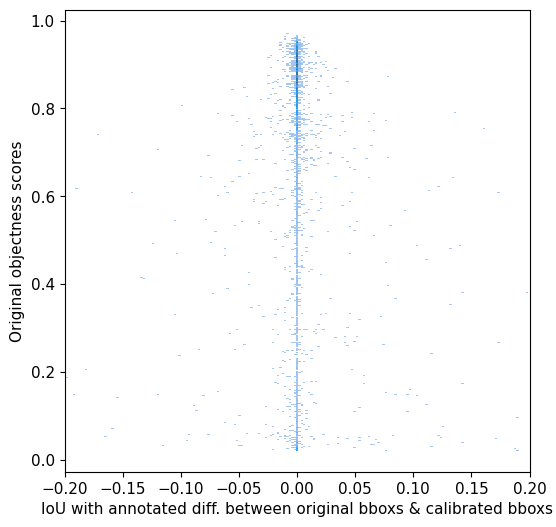

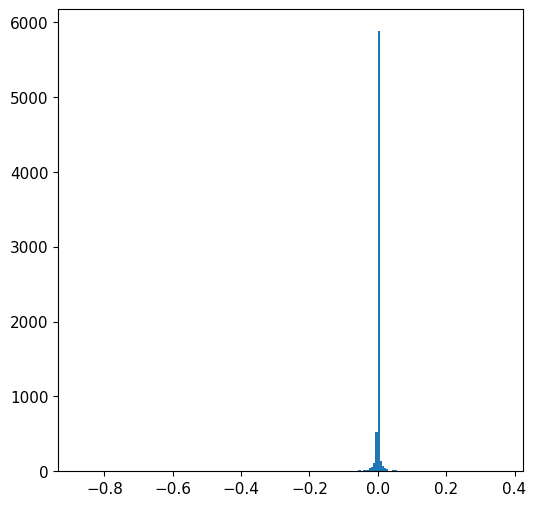

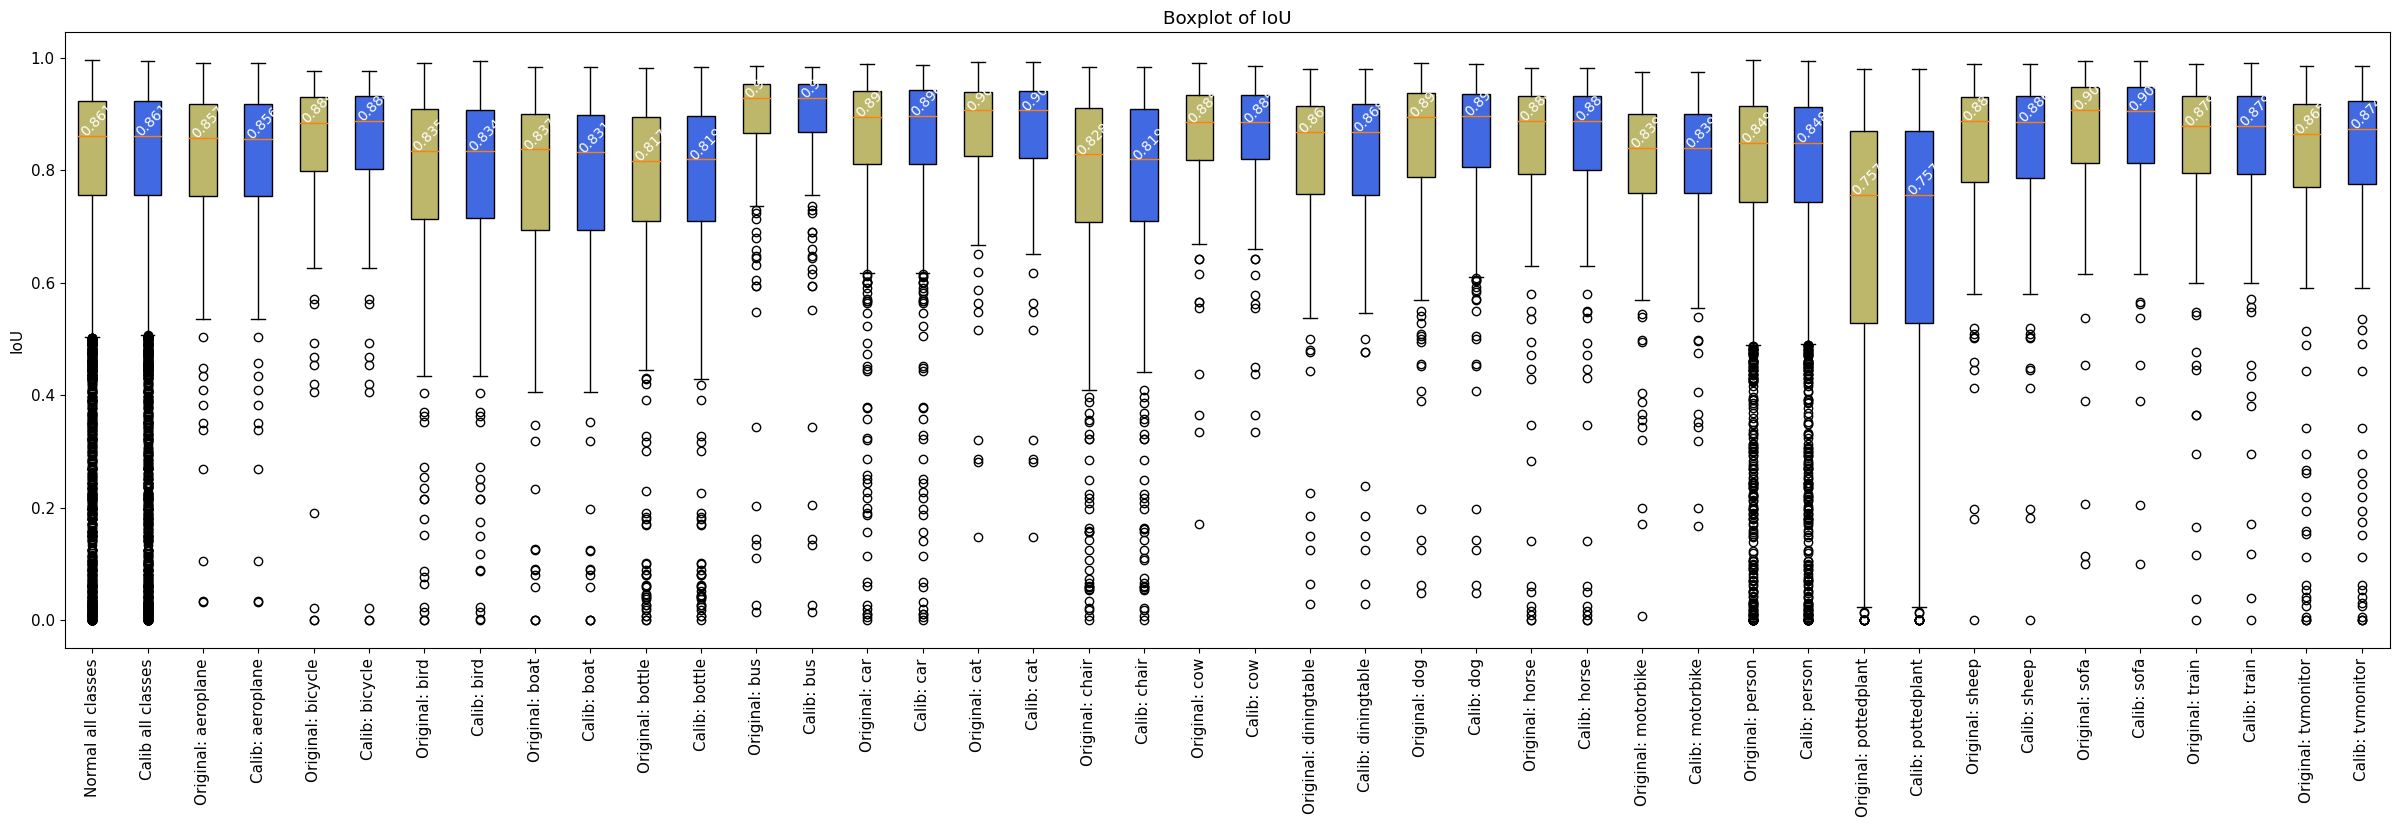

In [23]:
df_ = pd.DataFrame(zip(max_IoU_original_values, max_IoU_calibrated_values, max_IoU_original_values_obj, max_IoU_calibrated_values_obj, np.vstack([x.cpu().numpy() for x in labels_for_mAP])[:, 0]), columns=["normal_IoU", "calibrated_IoU", "normal_obj", "calibrated_obj", "labels"])
df_["diff_IoU"] = df_["normal_IoU"] - df_["calibrated_IoU"]
df_["labels_name"] = df_["labels"].map(var.names)
print("Old vs New values")
display(df_.describe().round(4))

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
sns.histplot(ax=ax1, data=df_, x="diff_IoU", y="normal_obj", stat="percent", common_norm=False, bins=600)
ax1.set_xlim((-0.2, 0.2))
plt.xlabel("IoU with annotated diff. between original bboxs & calibrated bboxs")
plt.ylabel("Original objectness scores")
plt.savefig(pic_save_dir_+"_diff_calibrated_iou.png", bbox_inches="tight")
plt.show()


fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
ax1.hist(df_["diff_IoU"], bins=200)
plt.savefig(pic_save_dir_+"_diff_calibrated_iou_hist.png", bbox_inches="tight")
plt.show()

# Boxplot
box_colors = ['darkkhaki', 'royalblue']
data = [df_.normal_IoU, df_.calibrated_IoU]
labels = ["Normal all classes", "Calib all classes"]
fig, ax = plt.subplots(figsize=(30, 8))
for i, label_ in enumerate(np.unique(df_.labels_name)):
    color_ = np.where(np.array(df_.labels_name)==label_)
    data.extend([np.array(df_.normal_IoU)[color_]])
    data.extend([np.array(df_.calibrated_IoU)[color_]])
    labels.extend(["Original: "+str(label_)])
    labels.extend(["Calib: "+str(label_)])
        
bplot1 = ax.boxplot(
    data,
    labels=labels,
    vert=True,  # vertical box alignment
    patch_artist=True,  # fill with color
)
medians = []
text_x = []
for item in bplot1["medians"]:
    medians = np.round(item.get_data()[1].mean(), 3)
    ax.text(np.round(item.get_data()[0][0], 3), medians, medians, color='white', fontsize=10, rotation=45)

for patch, color in zip(bplot1['boxes'], box_colors*(var.nc+1)):
    patch.set_facecolor(color)
        
plt.ylabel("IoU")
plt.title("Boxplot of IoU")
plt.xticks(rotation=90)
plt.savefig(pic_save_dir_+"_normal_vs_calibrated_iou_boxplot_isotonic.png", bbox_inches="tight")
plt.show()

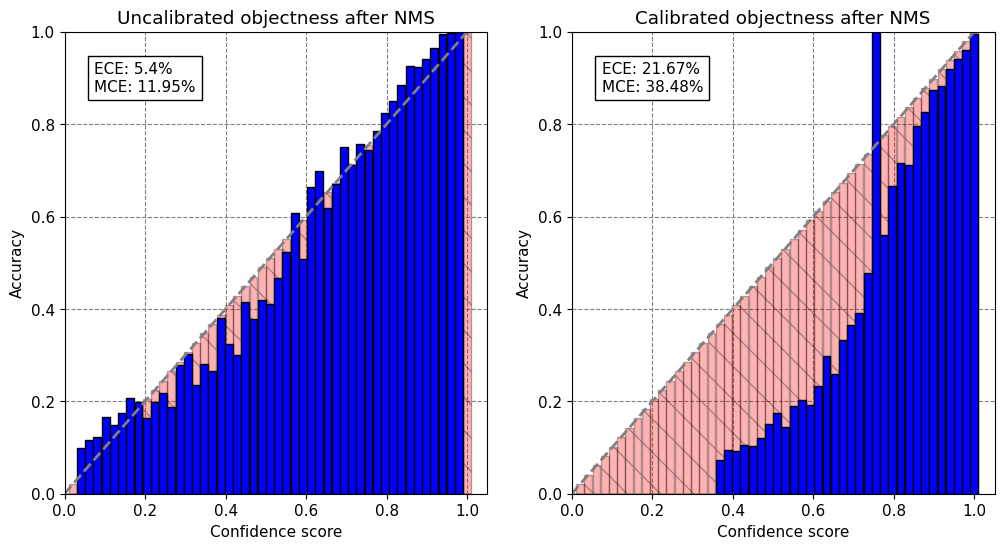

In [24]:
obj_ = [] 
obj_NAME = names_copy_original[1]
obj_true_ = []
obj_true_NAME = obj_NAME+"_Ocalib_obj_y_true"

obj_calib_ = [] 
obj_calib_NAME = names_copy_calibrated[1]
obj_calib_true_ = [] 
obj_calib_true_NAME = obj_calib_NAME+"_Ocalib_obj_y_true"


for path in test_dict:
    values_ = test_dict[path]
    if (values_["has_detec"]==1):
        if (values_[obj_NAME].shape[0] != 0):
            obj_.extend(values_[obj_NAME].ravel())
            obj_true_.extend(values_[obj_true_NAME].ravel())

for path in test_dict:
    values_ = test_dict[path]
    if (values_["has_detec"]==1):
        if (values_[obj_calib_NAME].shape[0] != 0):
            obj_calib_.extend(values_[obj_calib_NAME].ravel())
            obj_calib_true_.extend(values_[obj_calib_true_NAME].ravel())

fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(12, 6))
draw_reliability_graph(np.array(obj_), np.array(obj_true_), config.num_bins, strategy="uniform", title="Uncalibrated objectness after NMS", axs=axs1)
draw_reliability_graph(np.array(obj_calib_), np.array(obj_calib_true_), config.num_bins, strategy="uniform", title="Calibrated objectness after NMS", axs=axs2)
plt.savefig(pic_save_dir_+"obj_bf_nms_calib_af_nms_ece.png", bbox_inches="tight")


In [25]:
def sol2(arr, indexes):
    mask = np.ones(arr.size, dtype=bool)
    mask[indexes] = False
    return mask
    

def show_image(full_path, dict_, names):
    image = cv2.imread(full_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    true_bbox_NAME = names[0]
    bbox_original = names[1]
    bbox_calib = names[2]
    conf_original = names[3]
    conf_calib = names[4]
    
    values_ = dict_[full_path]
    values_obj_ = dict_[full_path]

    print(full_path)
    print("# of total labelled BBOX: ", values_[true_bbox_NAME].shape[0])
    print("# of total BBOX normal NMS: ", values_[bbox_original].shape[0])
    print("# of total BBOX calib NMS: ", values_obj_[bbox_calib].shape[0])

    for i, bbox in enumerate(values_[true_bbox_NAME]):
        sp, ep = (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3]))
        color = (255,250,250)
        image = cv2.rectangle(image, sp, ep, thickness=1, color=(255,250,250))

    thres_pic_ = 0.8
    
    same_pictures_iou = box_iou(
        torch.tensor(values_[bbox_original], device=device),
        torch.tensor(values_obj_[bbox_calib], device=device)
    )>thres_pic_
    
    same_pictures_normal = list(set(same_pictures_iou.max(axis=1).indices.cpu().numpy()))
    same_pictures_calib = list(set(same_pictures_iou.max(axis=0).indices.cpu().numpy()))

    not_same_pictures_normal = np.arange(0, values_obj_[bbox_calib].shape[0])[sol2(np.arange(0, values_obj_[bbox_calib].shape[0]), same_pictures_normal)]
    not_same_pictures_calib = np.arange(0, values_[bbox_original].shape[0])[sol2(np.arange(0, values_[bbox_original].shape[0]), same_pictures_calib)]


    for i, bbox in enumerate(values_[bbox_original]):
        sp, ep = (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3]))
        text_ = str(np.round(values_[conf_original][i][0], 2))
        color = (138,43,226)
        image = cv2.rectangle(image, sp, ep, thickness=2, color=color)
        image = cv2.putText(image, text_, (sp[0], sp[1] + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, color, 1)
        
    for i, bbox in enumerate(values_obj_[bbox_calib]):
        sp, ep = (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3]))
        text_ = str(np.round(values_obj_[conf_calib][i][0], 2))
        color = (135,206,250)
        image = cv2.rectangle(image, sp, ep, thickness=1, color=color)
        image = cv2.putText(image, text_, (sp[0], sp[1] + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.3, color, 1)

    print("Normal NMS # chosen bbox: ", len(not_same_pictures_calib))
    print("Calib NMS # chosen bbox: ", len(not_same_pictures_normal))
    return image
        

In [26]:
test_dict[list(test_dict.keys())[0]].keys()

dict_keys(['bbox_xywh', 'bbox_xyxy_scaled', 'obj', 'class', 'bbox_xyxy_scaled_nms', 'obj_nms', 'class_nms', 'annot_image_shape', 'annot_bbox_xyxy_scaled', 'annot_bbox', 'annot_class', 'has_detec', 'bbox_xywh_Ocalib', 'obj_Ocalib', 'class_Ocalib', 'bbox_xyxy_scaled_Ocalib', 'obj_Ocalib_obj_y_true', 'obj_Ocalib_calib_obj_score', 'bbox_xyxy_scaled_Ocalib_nms_scaled', 'obj_Ocalib_calib_obj_score_nms', 'class_Ocalib_nms', 'bbox_xyxy_scaled_Ocalib_nms_scaled_Ccalib', 'obj_Ocalib_calib_obj_score_nms_Ccalib', 'class_Ocalib_nms_Ccalib', 'class_Ocalib_nms_Ccalib_class_y_true', 'class_Ocalib_nms_Ccalib_calib_class_score', 'bbox_xyxy_scaled_nms_Ocalib', 'obj_nms_Ocalib', 'class_nms_Ocalib', 'obj_nms_Ocalib_obj_y_true', 'bbox_xyxy_scaled_Ocalib_nms_scaled_Ccalib_Ocalib', 'obj_Ocalib_calib_obj_score_nms_Ccalib_Ocalib', 'class_Ocalib_nms_Ccalib_calib_class_score_Ocalib', 'obj_Ocalib_calib_obj_score_nms_Ccalib_Ocalib_obj_y_true'])

/Users/llacombe/CODE/Thesis_code/datasets/VOC/images/test2007/004243.jpg
# of total labelled BBOX:  11
# of total BBOX normal NMS:  26
# of total BBOX calib NMS:  25
Normal NMS # chosen bbox:  2
Calib NMS # chosen bbox:  1


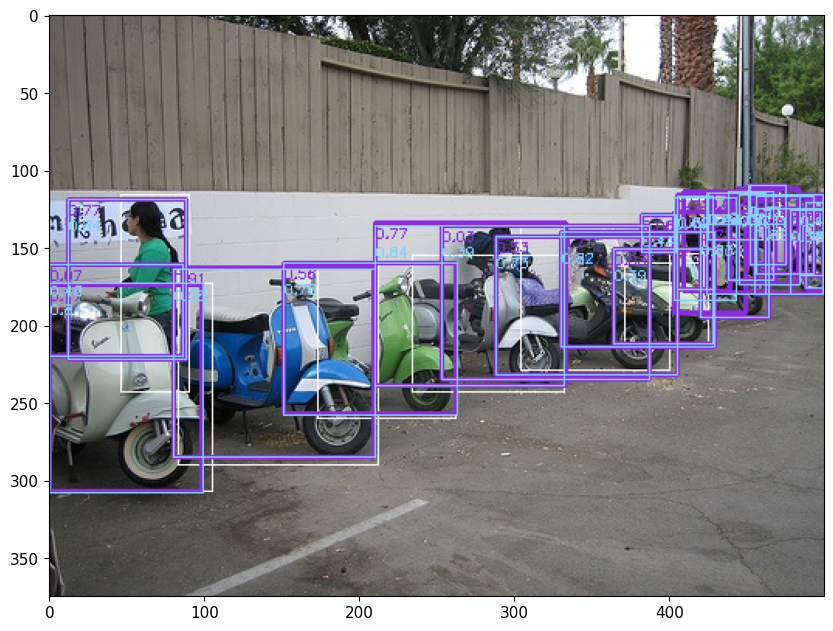

In [28]:
names = ["annot_bbox_xyxy_scaled", "bbox_xyxy_scaled_nms", "bbox_xyxy_scaled_Ocalib_nms_scaled", "obj_nms", "obj_Ocalib_calib_obj_score_nms"]

path = list(test_dict.keys())[129]
image = show_image(path, test_dict, names)
fig, axes = plt.subplots(1, 1, figsize = (10,10))
axes.imshow(image) #[1550:2000, 400:800]
fig.savefig(pic_save_dir_+'_full_figure.png', bbox_inches="tight")